>#### Imports and Calling in Data:

In [1]:
#imports for calling in data
import wrangle
import viz

df=wrangle.get_zillow_data()

#needed imports for general notebook needs
import pandas as pd
pd.options.display.max_rows = 100
import matplotlib.pyplot as plt
import seaborn as sns



# Acquisition Phase:

>### Summary of the Raw Acquired Data:

In [2]:
#using a summary df built in wrangle.py
wrangle.df_summary(df)

---Shape: (52319, 68)

---Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet 

# Preparation Phase:

>### Handling the nulls and Missing Values & dtypes

Notes:
    <br>- I first handled my missing values by determining the count and percentage missing from each feature, and found that with rows & columns, taking out the data that had 60% columns and 60% of rows data missing did not affect my data count by much AND left me with some good features that I think will help conduct the clustering model. 
    <br>- I then changed the dtypes all to int for later scaline/modeling.

In [3]:
#bringing in my function that 1) Handled missing values by %, 2)dropped unneeded feature columns, 3) dropna the smaller 
#amount of nulls that were missing by row
df = wrangle.data_prep(df, cols_to_remove=['propertylandusetypeid','transactiondate','propertycountylandusecode','propertylandusedesc','propertyzoningdesc','buildingqualitytypeid','heatingorsystemtypeid','unitcnt','heatingorsystemdesc','calculatedbathnbr','id','finishedsquarefeet12','fullbathcnt','structuretaxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','regionidcity','censustractandblock'], prop_required_column=.6, prop_required_row=.6)

In [4]:
#just to show what columns were left and that nulls are now cleaned
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
rawcensustractandblock          0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
assessmentyear                  0
logerror                        0
dtype: int64

>### Split the Data:

In [5]:
#using a 80/20 split on Train/Test, and then 70/30 for train,validate...stratifying on fips for even mix of data between
#using the fips codes for the three counties
train, validate, test = wrangle.split_data(df)
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror
34222,11533536,1.0,2.0,864.0,6037.0,33986536.0,-118424309.0,5002.0,6.037275e+07,3101.0,96047.0,0.0,1950.0,787004.0,2016.0,0.063660
21551,11058331,2.0,3.0,1243.0,6037.0,34270033.0,-118492886.0,7795.0,6.037111e+07,3101.0,96370.0,0.0,1953.0,174930.0,2016.0,0.059323
39107,14003091,2.0,4.0,1157.0,6059.0,33794310.0,-117985512.0,7350.0,6.059088e+07,1286.0,97023.0,7.0,1954.0,274539.0,2016.0,0.184348
9029,14208016,2.0,3.0,1491.0,6059.0,33861905.0,-117769542.0,6000.0,6.059022e+07,1286.0,97027.0,6.0,1975.0,523394.0,2016.0,-0.004648
2982,10844442,2.0,4.0,1843.0,6037.0,34173761.0,-118454651.0,7202.0,6.037128e+07,3101.0,96420.0,0.0,1949.0,113758.0,2016.0,0.025679


>### Encoding Columns:
I want to encode the 'fips' column, and added the columns 'is_Los_Angeles'/'is_Ventura'/'is_Orange' so I can use a quick 0/1 to use in predictions.

In [6]:
#encoded column for counties
train = wrangle.one_hot_encode(train)
#turned columns into int
train = wrangle.dtype_county(train)

>### Data Distributions:
- Looking at each feature and it's distribution

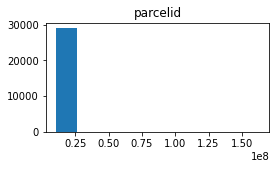

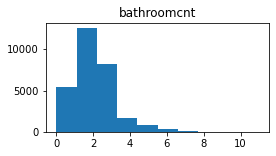

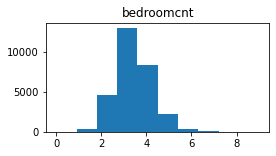

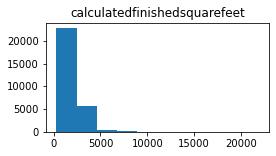

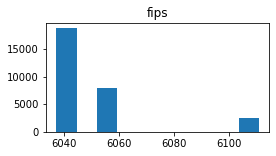

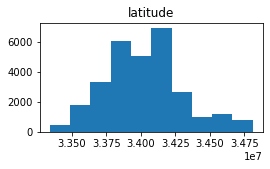

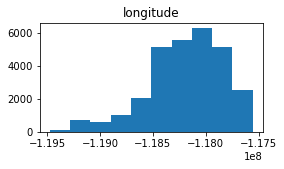

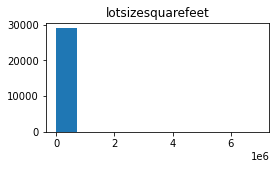

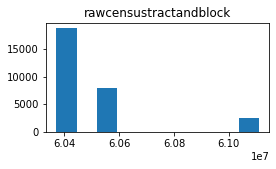

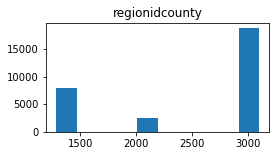

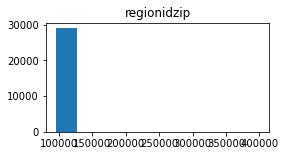

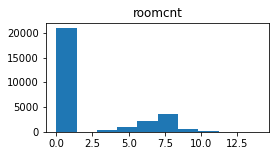

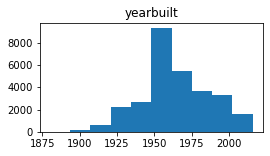

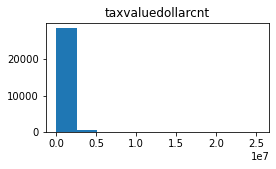

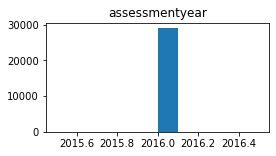

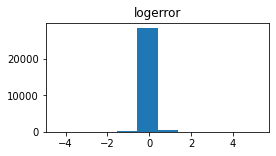

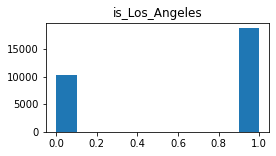

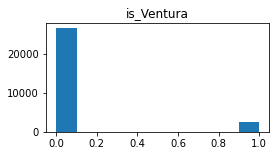

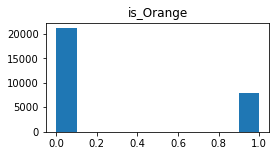

In [7]:
#create all the histograms:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

##### TAKEAWAYS:
- I'll add in some outlier ranges to help these distributions look at bit more 'normal'
- Some columns won't need to be changed (ie. latitude/longitude/zipcode/census/etc)
- Depending on the shape after outliers, for the right-tailed features I'll use a Spearman's test (since shape of data is not normally distributed)

>### Outliers: Creating the ranges of data to train on

In [11]:
train = wrangle.handle_outliers(train)

I'll be using the ranges I set in my Regression project to handle outliers:

- Finished Squarefoot Range: 200sqft - 9_000sqft
- Bedroom Count range: 1-6bd
- Bathroom Count range:1-6bd
- Property Tax Value range: 45k - 2.5million

And adding new ranges of:

- Year built: 1950 - 2016
- Lot Sqft: 2,500 - 435,600 (10acres)...based on CA requirements for minimum and capturing more of Zillow's max clients

### Conclusion: The above ranges gave me a data count of 20,875 rows X 19 columns.
>### <mark>Taking out 28% of training data</mark>

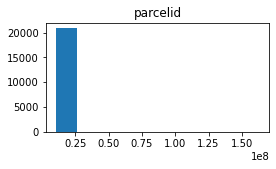

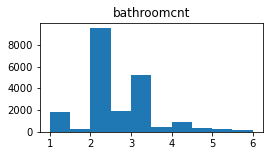

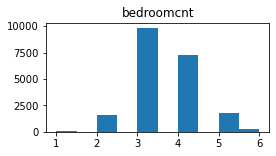

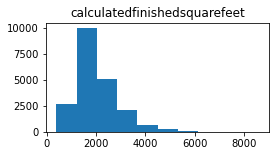

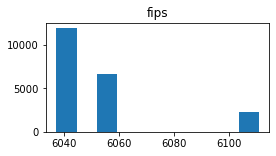

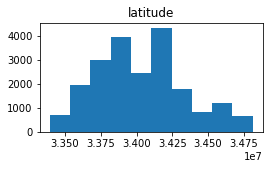

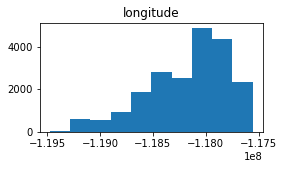

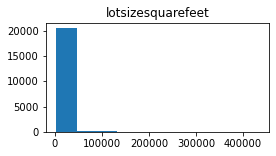

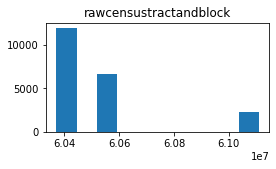

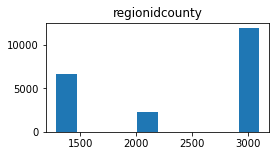

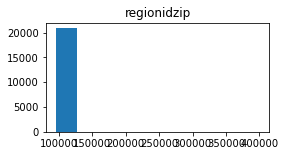

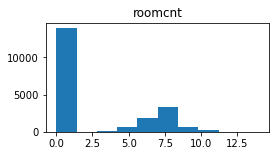

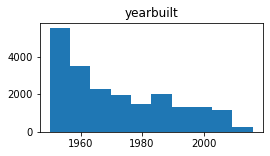

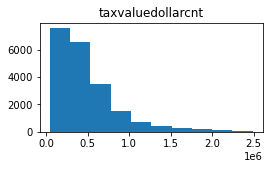

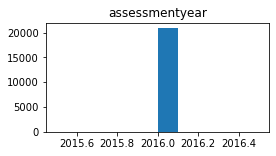

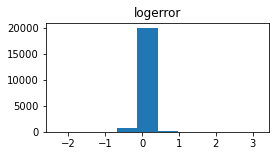

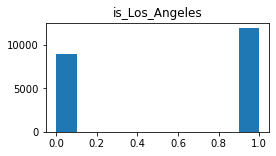

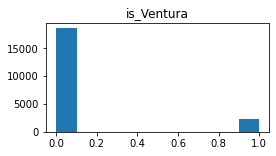

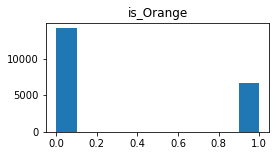

In [12]:
#Looking once more at the distribution, now that the outliers have been sorted out
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

____________________________________________________________________________________________________

# Question One: Does logerror differ across each county?

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

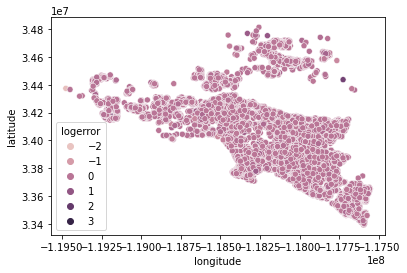

In [13]:
#I created a scatterplot to give a visualization of logerrors based on location/county/region
sns.scatterplot(data=train, x='longitude', y='latitude', hue='logerror')

### Take away: The region plot shows that the mean of logerrors is happening all across each of our 3 counties...so I would at least say there isn't 'one' county that is ONLY experiencing these log errors...